In [12]:
%matplotlib inline
from scipy.io import loadmat,savemat
from scipy.linalg import *
from numpy import *
from os import listdir
import pickle,operator
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor

In [13]:
titaniumDat = loadmat('alphatitaniumsmall.mat')
volumefraction = constraint = titaniumDat['volumefraction'][0]

### <font color="red">Objective: Maximize the thermal expansion coefficient alpha</font>


## <font color="blue"> Optimization problem formulation:</font>

### <font color="green">max alpha</font>
subject to :
#####  <font color="orange">   161<=C11<=165</font>
#####  <font color="orange">  75<=C12<=78</font>

In [14]:
def FiveSig(x):
    return float("{0:.5f}".format(x))

In [15]:
def Plot(x,y,labelX="",labelY="",title=""):
    plt.plot(x,y)
    plt.xlabel(labelX)
    plt.ylabel(labelY)
    plt.title(title)

In [16]:
def getC11C12(odf):

    C = stiffness.dot(odf).reshape(6,6);  # averaged stiffness matrix
    C11 = C[0][0]
    C12 = C[0][1]
    return C11, C12

In [17]:
def posOdf(odf):
    return nonzero(odf)[0].tolist()

def getSum(odf):
    Sum = 0
    for i in range(50):
        Sum += volumefraction[i]*odf[i]
    return Sum

def checkSum(odf):
    Sum = FiveSig(getSum(odf))
    if Sum !=1.0:
        return False
    else:
        return True

In [18]:
def loadData(name,path):
    '''
    This loads a pickle file and returns the content which is a DICTIONARY object in our case.
    '''
    if ".pkl" in name:
            name = name.split(".pkl")[0]
    if "/" in name:
            name = name.split("/",1)[1]

    with open(path+"/"+name + '.pkl', 'rb') as f:
          return pickle.load(f)

def saveData(obj, name,path):
    '''
    This saves a object into a pickle file. In our case, it is generally a DICTIONARY object.
    '''

    with open(path+"/"+name + '.pkl', 'wb') as f:
            pickle.dump(obj, f)#, pickle.HIGHEST_PROTOCOL)
            
def loadNumpy(name,path='numpyData'):
    fullPath = path+'/'+name+'.npy'
    return load(fullPath)
    

def saveNumpy(obj, name, path='numpyData'):
    fullPath = path+'/'+name
    save(fullPath, obj)
    print name,'saved successfully in',path

### <font color="red">Optimum polycrystal solution alpha = 8.5506e-06</font>
#### with 
##### <font color="blue"> C11 = 161.0000 GPa, C12 = 75.0000 GPa</font>

In [19]:
data = []

Filename = []
for File in listdir('alphaUpperData'):

    Filename += [File]
    data += [loadmat('alphaUpperData/'+File)]

In [22]:
len(data[0]['Data'][0])

391

In [9]:
opts = []
odfs = []
constraint1 = []
constraint2 = []
# sortedOpts = []
# sortedConstraints = []

maxOdf = [[0]*50]*len(data)#, maxOdf]#, maxOdf]#, maxOdf]
maxOpt = [0]*len(data)#4
maxConstraint1= [0]*len(data)
maxConstraint2 = [0]*len(data)

count = 0
total = 0

for i in range(len(data)):
    for odf in data[i]['Data']:
        
        odf = odf.tolist()
        opts += [odf[52]]
        constraint1 += [odf[50]]
        constraint2 += [odf[51]]
        
        odfs += [odf[:50]]
        
        total += 1
        
        if checkSum(odf[:50]):
            count += 1

        if odf[52]>maxOpt[i]:
            maxOpt[i] = odf[52]
            maxConstraint1[i] = odf[50]
            maxConstraint2[i] = odf[51]
            maxOdf[i] = odf[:50]

In [10]:
combined = zip(constraint1,constraint2,opts,odfs)
#combined.sort(key=lambda i: int(i[1]), reverse=True)
combined.sort(key=lambda x:map(float, str(float(x[2])).split(".")), reverse=True)
constraint1[:],constraint2[:],opts[:],odfs[:] = zip(*combined)

In [15]:
saveNumpy(constraint1,'sortedConstraint1_alpha_v3')
saveNumpy(constraint2,'sortedConstraint2_alpha_v3')
saveNumpy(odfs,'sortedOdfs_alpha_v3')
saveNumpy(opts,'sortedOpts_alpha_v3')

sortedConstraint1_alpha_v3 saved successfully in numpyData
sortedConstraint2_alpha_v3 saved successfully in numpyData
sortedOdfs_alpha_v3 saved successfully in numpyData
sortedOpts_alpha_v3 saved successfully in numpyData


In [16]:
orderOpts = []
for opt in opts:
    orderOpts += [opt*pow(10,6)]

In [17]:
edgeOdfs = odfs[:5000]+odfs[-5000:]
edgeLabels = orderOpts[:5000]+orderOpts[-5000:]

edgeOdfs,edgeLabels = shuffle(edgeOdfs,edgeLabels)

In [18]:
clf = RandomForestRegressor(max_depth=2, random_state=0)
clf.fit(edgeOdfs, edgeLabels)
features = clf.feature_importances_
indices = argsort(features)[::-1]
values = sorted(features, reverse=True)
for i in range(3):
    print indices[i], ':',values[i]

21 : 0.517455555584
20 : 0.482544444416
49 : 0.0


In [20]:
LP = 8.5506e-06
limit1 = 0.98 *LP
limit2 = 0.99 *LP
limit3 = 0.995 *LP
limit1,limit2,limit3

(8.379588e-06, 8.465094e-06, 8.507847e-06)

In [21]:
count1,count2,count3,count4 = 0,0,0,0
flag,i = True,-1
flag1,flag2 = -1,-1
while flag:
    i+=1
    if opts[i]>limit1:
        count1 += 1
        if opts[i]>limit2:
            count2 += 1
            if opts[i]>limit3:
                count3 += 1
#                 if opts[i]>limit4:
#                     count4 += 1
    else:
        flag = False

print count1, count2,count3

76 6 0


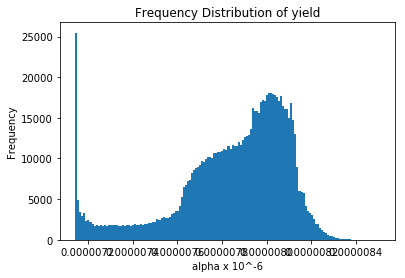

In [22]:
plt.hist(opts,bins=150)
plt.title("Frequency Distribution of yield")
plt.xlabel("alpha x 10^-6")
plt.ylabel("Frequency")
plt.show()

In [15]:
for i in range(len(data)):
    print i,Filename[i],maxOpt[i]

0 alpha_SmallPartition2_1000.mat 8.17374449993e-06
1 alpha_SmallPartition2_150000.mat 8.23894653981e-06
2 alpha_SmallPartition4_300000.mat 8.47473013943e-06
3 alpha_SmallPartition7_1000000.mat 8.40968298254e-06
4 alpha_SmallPartition9_300000.mat 8.36464489658e-06
5 data1_first3Generator_50000.mat 8.39280126781e-06
6 data1_first4Generator_3000.mat 8.28683195813e-06
7 data1_first4Generator_50000.mat 8.38230117219e-06
8 data1_first5Generator_2000.mat 8.29848883699e-06
9 data1_first5Generator_200000.mat 8.36518413247e-06
10 data1_first5Generator_3000.mat 8.28203062114e-06
11 data1_first6Generator_200000.mat 8.37637156554e-06
12 data1_first7Generator_50000.mat 8.34820481704e-06
13 data_SmallPartition15_500000.mat 8.34448619876e-06
14 data_SmallPartition2_1000000.mat 8.25465173964e-06
15 data_SmallPartition2_250000.mat 8.26886780278e-06
16 data_SmallPartition3_1000000.mat 8.43336742794e-06
17 data_SmallPartition3_250000.mat 8.39730431225e-06
18 data_SmallPartition4_1000000.mat 8.46295370202e

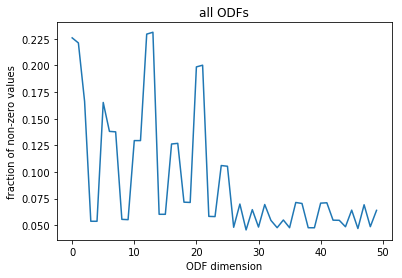

In [24]:
indices = list(range(50))
List = []
for i in range(50):
    List += [0]
    
for odf in odfs:
    nz = nonzero(odf)[0].tolist()
    for elem in nz:
        List[elem] += 1

average = []
for i in indices:
    average += [float(List[i])/float(len(odfs))]
Plot(indices, average,"ODF dimension","fraction of non-zero values","all ODFs")

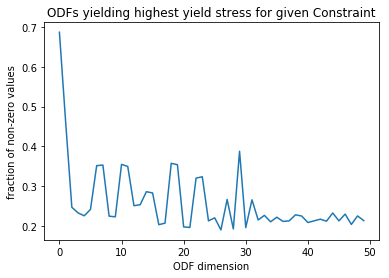

In [26]:
topOdfs = odfs[:5000]
topList = []
for i in range(50):
    topList += [0]
    
for odf in topOdfs:
    nz = nonzero(odf)[0].tolist()
    for elem in nz:
        topList[elem] += 1

topAverage = []
for i in indices:
    topAverage += [float(topList[i])/float(len(topOdfs))]
Plot(indices, topAverage,"ODF dimension","fraction of non-zero values","ODFs yielding highest yield stress for given Constraint")

In [27]:
dictionary = {}
for i in range(len(indices)):
    dictionary[indices[i]]=topAverage[i]
sorted_dict = sorted(dictionary.items(), key=operator.itemgetter(1),reverse=True)
sorted_dict[:10]

[(0, 0.6872),
 (1, 0.4618),
 (29, 0.3876),
 (18, 0.3572),
 (10, 0.3546),
 (19, 0.3538),
 (7, 0.3528),
 (6, 0.3514),
 (11, 0.3494),
 (23, 0.3234)]

In [28]:
for i in range(20):
    print posOdf(odfs[i])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
[0, 9, 18, 29]
[0, 18, 22, 29]
[0, 19, 29, 33]
[0, 14, 18, 25, 29, 33]
[0, 6, 8, 19, 24, 29]
[0, 10, 18, 29]
[0, 18, 19, 29, 31, 38]
[0, 7, 18, 27, 29, 43, 44]
[0, 7, 19, 29, 40]
[0, 10, 18, 23, 29]
[0, 19, 29, 33, 47]
[0, 10, 19, 29]
[1, 23, 29]
[0, 19, 29]
[0, 8, 18, 20, 29, 45]
[0, 7, 12, 18, 19, 29, 40]
[0, 23, 29]
[0, 12, 19, 29, 34, 36, 44, 46]
[0, 4, 23, 29, 30]
